# Master Thesis: Predicting Tech Workers' Mental Health Condition using Machine Learning Techniques

# Pre-Processing

## Importing Library

In [2]:
#pip install xgboost

import pandas as pd
import numpy as np
from pandasql import sqldf
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC # "Support vector classifier"

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn import metrics
import itertools

pysqldf = lambda q: sqldf(q, globals())
pd.set_option('display.max_columns', None)

## Loading the Dataset

In [3]:
df = pd.read_csv("Final Data.csv",na_values="NaN")


# Remove Warning
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
df.shape

(1836, 85)

## Data Cleaning

In [5]:
# Dropping Column
def remove_column(df,column_name):
    df = df.loc[:, ~df.columns.str.contains(column_name)]
    return df 

df = remove_column(df, "qual")
df = remove_column(df, "date")
df = remove_column(df, "network")
df = remove_column(df, "covid")
df = remove_column(df, "ad_hoc")
df = remove_column(df, "country")
df = remove_column(df, "state")
df = remove_column(df, "prvemp")
df= df.drop(columns=['unique_id','year','race'])

# Replacing None with NA
df = df.fillna(value=np.nan)

# Cleaning "Gender" Column
df = sqldf("SELECT *, CASE WHEN lower(gender) like 'f' then 'female' WHEN lower(gender) like '%female%' then 'female' WHEN lower(gender) like '%woman%' then 'female' WHEN lower(gender) like 'm' then 'male' WHEN lower(gender) like '%-male' then 'male' WHEN lower(gender) like '% male' then 'male' WHEN lower(gender) like 'man' then 'male' WHEN lower(gender) like 'male%' then 'male' ELSE 'unidentified' end as 'new_gender'from df  ;", locals())
df= df.drop(columns=['gender'])

# Cleaning "Count Employees" Column
df = sqldf("SELECT *, case when count_employees ='Jun-25' then '6-25' when count_employees = '01-May' then '0-5' else count_employees end as count_employees_new from df;", locals())
df= df.drop(columns=['count_employees'])

#Dropping Anomaly in Age
df = df.loc[(df['age'] > 1)]
df = df.loc[(df['age'] < 100)]


In [6]:
# Dropping Column with Total Response < 50% 
df = df.dropna(thresh=((len(df)*0.7)),axis = 1)
# Dropping Row with Total Response < 50% 
df ['NA_per_row'] = df.isnull().sum(axis=1)
df = df.loc[df['NA_per_row'] < ((len(df. columns)*0.3))]
df= df.drop(columns=['NA_per_row'])

In [7]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)
numeric_columns =  list(df.select_dtypes(include=['float64']).columns)
all_column_name = list(df.columns)
df.shape

(1575, 36)

In [9]:
df['self_current_mh_dis'].value_counts()

Yes           649
No            466
Possibly      328
Don't Know    132
Name: self_current_mh_dis, dtype: int64

In [11]:
len(df['self_current_mh_dis'])

1575

## Impute the Missing Data

In [9]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_new = imp.fit_transform(df)
#df_new
#df_new = df.apply(SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform)
df_new = pd.DataFrame(data=df_new)
df_new.columns = all_column_name
#df_new.head(10)

## Feature Encoder

In [10]:
# Splitting Data into x (feature) and y (target attribute)
x = df_new.drop(columns=['self_current_mh_dis'])
y = df_new['self_current_mh_dis']

# Converting Target Attribute from 4 class into 3 class
y_new = sqldf ("select case when self_current_mh_dis = 'Yes' then 'Yes' when self_current_mh_dis = 'No' then 'No' else 'Maybe' end as self_current_mh_dis from y ;", locals())
y_new = sqldf ("select case when self_current_mh_dis = 'Yes' then 1 when self_current_mh_dis = 'No' then 0 else 2 end as y_numeric from y_new ;", locals())
y_new = np.asarray(y_new)

# Coding Feature into Numerical
all_feature = list(x.columns)
le = preprocessing.LabelEncoder()
x_new = x.apply(preprocessing.LabelEncoder().fit_transform)


In [10]:
x_new.shape

(1575, 35)

In [25]:
df[categorical_columns].to_csv("df_categorical.csv")

In [26]:
df[numeric_columns].to_csv("df_numeric.csv")

## Split the Data into Training & Validation Set

In [11]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, test_size = 0.3, random_state = 3)

# Normalization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [12]:
X_test.shape

(473, 35)

***

# Run the Prediction Model & Evaluation

## Logistic Regression

### Training the Model

In [13]:
log_reg = LogisticRegression(random_state = 0)
log_reg.fit(X_train, y_train.ravel())
log_reg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [14]:
param_grid = [    
    {
    #'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

#grid = RandomizedSearchCV(svc,param_grid,refit=True,verbose=1)

log_reg_cv = RandomizedSearchCV(log_reg, param_grid,verbose=2, n_jobs=-1,scoring='f1_micro')
log_reg_cv.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=LogisticRegression(random_state=0), n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'liblinear', 'sag',
                                                    'saga']}],
                   scoring='f1_micro', verbose=2)

In [15]:
print ("The average f1 score from cross validation for Logistic Regression is", log_reg_cv.best_score_)

The average f1 score from cross validation for Logistic Regression is 0.7032373508844098


In [16]:
print ("The optimal model Logistic Regression is with parameter", log_reg_cv.best_params_)

The optimal model Logistic Regression is with parameter {'solver': 'liblinear', 'max_iter': 1000, 'C': 1.623776739188721}


### Predicting on Test Set

In [17]:
log_reg.set_params(**log_reg_cv.best_params_, random_state = 0)
y_pred = log_reg.predict(X_test)


print ("The f1 score for Logistic Regression is", f1_score(y_test, y_pred, average='micro'))

The f1 score for Logistic Regression is 0.6680761099365751


In [18]:
summary_f1 = {}
summary_f1['Logistic Regression'] = round(f1_score(y_test, y_pred, average='micro'),3)
summary_f1                              

{'Logistic Regression': 0.668}

Confusion matrix, without normalization


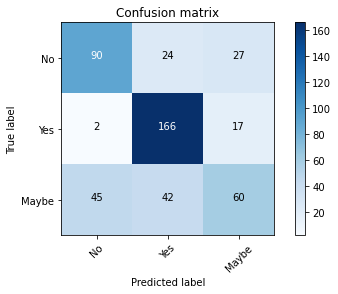

In [19]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['No', 'Yes','Maybe'])

## Support Vector Classifier

### Training the Model

In [20]:
svc = SVC()
svc.fit(X_train, y_train.ravel())
svc.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [21]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
svc_cv = RandomizedSearchCV(SVC(), param_grid, refit = True, verbose = 1,scoring='f1_micro')
 
# fitting the model for grid search
svc_cv.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   scoring='f1_micro', verbose=1)

In [22]:
print ("The average f1 score from cross validation for Support Vector Classifier is", svc_cv.best_score_)

The average f1 score from cross validation for Support Vector Classifier is 0.7095927601809955


In [23]:
print ("The optimal model Support Vector Classifier is with parameter", svc_cv.best_params_)

The optimal model Support Vector Classifier is with parameter {'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}


### Predicting on Test Data

In [24]:
svc.set_params(**svc_cv.best_params_,random_state=0)
y_pred = svc.predict(X_test)

print ("The f1 score for Support Vector Classifier is", f1_score(y_test, y_pred, average='micro'))

The f1 score for Support Vector Classifier is 0.6807610993657506


In [25]:
summary_f1['Support Vector Classifier'] = round(f1_score(y_test, y_pred, average='micro'),3)
summary_f1                              

{'Logistic Regression': 0.668, 'Support Vector Classifier': 0.681}

Confusion matrix, without normalization


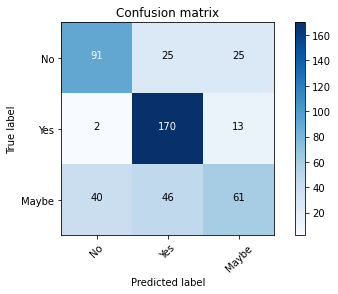

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['No', 'Yes','Maybe'])

## Random Forest Classifier

### Training the Model

In [27]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train.ravel())

RandomForestClassifier(random_state=0)

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(5, 50, 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(1, 50, 5)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
              }

# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, verbose=2, random_state=0, n_jobs = -1,
                               scoring='f1_micro')
# Fit the random search model
rf_random.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
                   param_distributions={'max_depth': [1, 6, 11, 16, 21, 26, 31,
                                                      36, 41, 46],
                                        'n_estimators': [5, 15, 25, 35, 45]},
                   random_state=0, scoring='f1_micro', verbose=2)

In [29]:
print ("The average f1 score from cross validation for Random Forest is", rf_random.best_score_)

The average f1 score from cross validation for Random Forest is 0.7313903743315509


In [30]:
print ("The optimal model Random Forest is with parameter", rf_random.best_params_)

The optimal model Random Forest is with parameter {'n_estimators': 35, 'max_depth': 26}


### Predicting on Test Set

In [31]:
rfc.set_params(**rf_random.best_params_,random_state=0)
y_pred = rfc.predict(X_test)

print ("The f1 score for Random Forest Classifier is", f1_score(y_test, y_pred, average='micro'))

The f1 score for Random Forest Classifier is 0.7082452431289642


In [32]:
summary_f1['Random Forest Classifier'] = round(f1_score(y_test, y_pred, average='micro'),3)
summary_f1            

{'Logistic Regression': 0.668,
 'Support Vector Classifier': 0.681,
 'Random Forest Classifier': 0.708}

Confusion matrix, without normalization


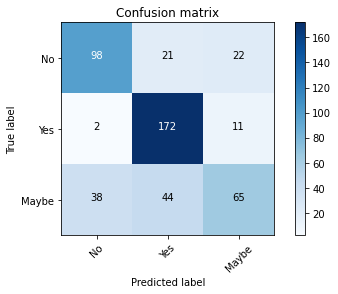

In [33]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['No', 'Yes','Maybe'])

## AdaBoost Classifier

### Training the Model

In [34]:
abc = AdaBoostClassifier(random_state=0)
abc.fit(X_train, y_train.ravel())

AdaBoostClassifier(random_state=0)

In [35]:
abc.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [36]:
%%time
#Creating a grid of hyperparameters
grid_params = {    'n_estimators':  [int(x) for x in np.arange(10,200,5)],
              'learning_rate': [(x) for x in np.arange(0.001,1,0.1)] } 
abc_random = RandomizedSearchCV(estimator = abc, param_distributions = grid_params, scoring = 'f1_micro', n_jobs = -1,verbose=2)
#Fitting the grid to the training data
abc_random.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 24 s


RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.101, 0.201,
                                                          0.30100000000000005,
                                                          0.401, 0.501,
                                                          0.6010000000000001,
                                                          0.7010000000000001,
                                                          0.801, 0.901],
                                        'n_estimators': [10, 15, 20, 25, 30, 35,
                                                         40, 45, 50, 55, 60, 65,
                                                         70, 75, 80, 85, 90, 95,
                                                         100, 105, 110, 115,
                                                         120, 125, 130, 135,
                                                         140, 145, 1

In [37]:
print ("The average f1 score from cross validation for AdaBoost is", abc_random.best_score_)

The average f1 score from cross validation for AdaBoost is 0.7359317153434801


In [38]:
print ("The optimal model AdaBoost is with parameter", abc_random.best_params_)

The optimal model AdaBoost is with parameter {'n_estimators': 180, 'learning_rate': 0.201}


### Predicting on Test Set

In [39]:
abc.set_params(**abc_random.best_params_,random_state=0)
y_pred = abc.predict(X_test)

print ("The F1 score for AdaBoost Classifier is", f1_score(y_test, y_pred, average='micro'))

The F1 score for AdaBoost Classifier is 0.6997885835095138


In [40]:
summary_f1['AdaBoost Classifier'] = round(f1_score(y_test, y_pred, average='micro'),3)
summary_f1            

{'Logistic Regression': 0.668,
 'Support Vector Classifier': 0.681,
 'Random Forest Classifier': 0.708,
 'AdaBoost Classifier': 0.7}

Confusion matrix, without normalization


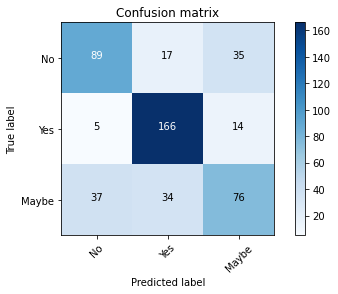

In [41]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['No', 'Yes','Maybe'])

## XGBoost Classifier

### Training the Model

In [42]:
xgb = XGBClassifier(use_label_encoder=False,random_state =0,importance_type='total_gain')
xgb.fit(X_train, y_train.ravel())

[21:28:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type='total_gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [43]:
xgb.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [44]:
%%time
## XGBoost Hyperparameter Tuning

param_test1 = {
 'booster' : ['gbtree', 'gblinear', 'dart'],
 'max_depth':range(1,10,1),
 'min_child_weight':range(1,5,1),
 'eta': [(x) for x in np.arange(0.01,0.5,0.01)],
 'objective' : 'multi:softmax',
 'gamma': [(x) for x in np.arange(0.01,10,0.1)],
 'max_delta_step':[(x) for x in np.arange(1,10,1)]
}


xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = param_test1,n_jobs = -1,scoring='f1_micro',verbose=2)
xgb_random.fit(X_train,y_train.ravel())


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[21:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 2s


RandomizedSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=0,
                                           gpu_id=-1,
                                           importance_type='total_gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_esti...
                                                  0.6100000000000001,
                                            

In [45]:
print ("The average f1 score from cross validation for XGBoost is", rf_random.best_score_)

The average f1 score from cross validation for XGBoost is 0.7313903743315509


In [46]:
print ("The optimal model XGBoost is with parameter", rf_random.best_params_)

The optimal model XGBoost is with parameter {'n_estimators': 35, 'max_depth': 26}


### Predicting on Test Set

In [47]:
xgb.set_params(**xgb_random.best_params_,random_state =0 )
y_pred = xgb.predict(X_test)


print ("The F1 score for XGBoost Classifier is", f1_score(y_test, y_pred, average='micro'))

The F1 score for XGBoost Classifier is 0.7124735729386892


Confusion matrix, without normalization


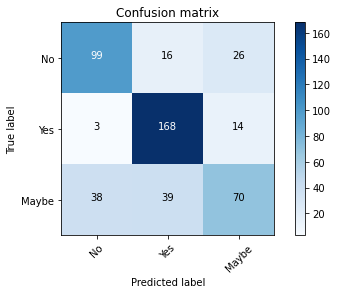

In [48]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['No', 'Yes','Maybe'])

In [49]:
summary_f1['XGBoost Classifier'] = round(f1_score(y_test, y_pred, average='micro'),3)
summary_f1            

{'Logistic Regression': 0.668,
 'Support Vector Classifier': 0.681,
 'Random Forest Classifier': 0.708,
 'AdaBoost Classifier': 0.7,
 'XGBoost Classifier': 0.712}

## Model Comparison

<AxesSubplot:xlabel='F1 Score', ylabel='algorithm'>

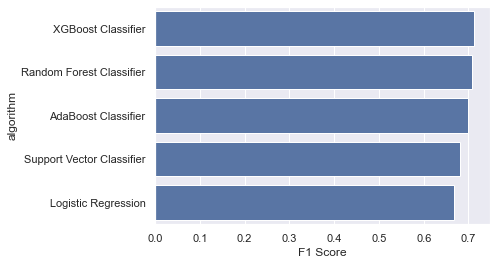

In [50]:
import seaborn as sns

df_summary_f1 = pd.DataFrame(summary_f1,index = [0])
df_summary_f1 = df_summary_f1.T.reset_index().rename(columns={"index": "algorithm", 0: "F1 Score"}).sort_values(by='F1 Score', ascending=False)

sns.set_theme(style="darkgrid")
sns.barplot(x="F1 Score", y="algorithm", data=df_summary_f1,
            label="Total", color="b")

***
# 3. Feature Importance

<BarContainer object of 11 artists>

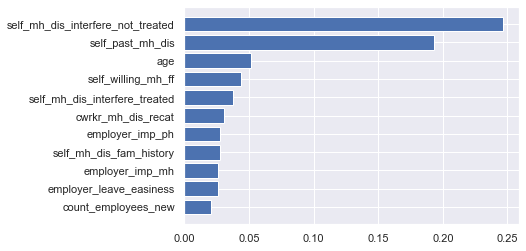

In [51]:
xgb_f1 = xgb.feature_importances_

def match_2 (x,y):
    a = {}
    for i in range (len(x)):
        a[x[i]] = y [i]
    a1 = pd.DataFrame.from_dict(a, orient='index').reset_index()
    a1 = a1.rename(columns={"index": "feature", 0: "importance"}).sort_values(by='importance', ascending=False)
    return a1



f = match_2(all_feature,xgb_f1)[0:11].sort_values(by='importance', ascending=True)
f_new = f['feature'][0:11]
pyplot.barh(f['feature'][0:11],f['importance'][0:11])
#pyplot.xticks(rotation=70)

In [52]:
 match_2(all_feature,xgb_f1)

,feature,importance
22,self_mh_dis_interfere_not_treated,0.246784
18,self_past_mh_dis,0.192778
32,age,0.051706
24,self_willing_mh_ff,0.043606
21,self_mh_dis_interfere_treated,0.037278
28,cwrkr_mh_dis_recat,0.030553
15,employer_imp_ph,0.027572
20,self_mh_dis_fam_history,0.027223
16,employer_imp_mh,0.026272
8,employer_leave_easiness,0.026230


***